In [10]:

import numpy as np # linear algebra
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torchaudio
import IPython.display as ipd
from torch.nn.utils.rnn import pad_sequence


g = torch.Generator()
g.manual_seed(42)

Loading audio file...
Converting to mel spectrogram...
Converting back to audio...


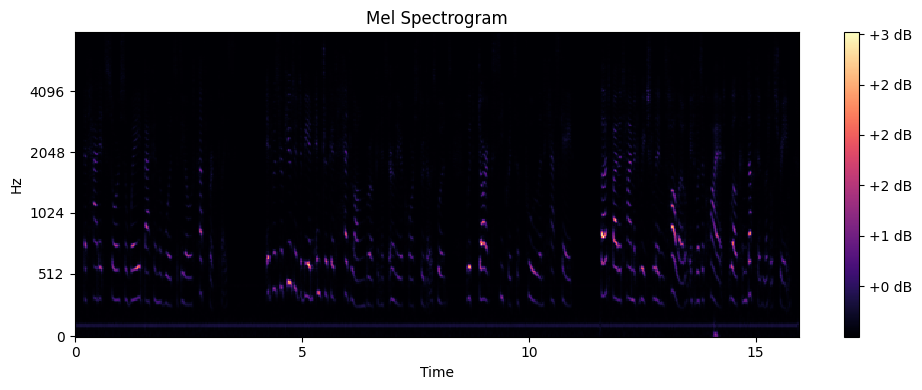

Saving reconstructed audio...
Processing completed successfully!


True

In [ ]:
import librosa
import librosa.display
import numpy as np
import torch
import torch.nn.functional as F
from scipy.io import wavfile

def stft(audio, n_fft=2048, hop_length=None, win_length=None):
    """
    Compute STFT with precise parameters
    """
    if hop_length is None:
        hop_length = n_fft // 4  # 75% overlap for better reconstruction
    if win_length is None:
        win_length = n_fft
    
    # Use more precise window
    window = np.blackman(win_length)
    
    return librosa.stft(
        audio,
        n_fft=n_fft,
        hop_length=hop_length,
        win_length=win_length,
        window=window,
        center=True,
        pad_mode='reflect'
    )

def istft(stft_matrix, hop_length=None, win_length=None, n_fft=2048):
    """
    Inverse STFT with precise parameters
    """
    if hop_length is None:
        hop_length = n_fft // 4
    if win_length is None:
        win_length = n_fft
        
    window = np.blackman(win_length)
    
    return librosa.istft(
        stft_matrix,
        hop_length=hop_length,
        win_length=win_length,
        window=window,
        center=True,
        length=None
    )

def audio_to_mel_spectrogram(audio, sr=16000):
    """
    Convert audio to mel spectrogram with minimal loss
    """
    # STFT parameters for high quality
    n_fft = 2048
    hop_length = n_fft // 4  # 75% overlap
    win_length = n_fft
    
    # Compute STFT
    D = stft(audio, n_fft=n_fft, hop_length=hop_length, win_length=win_length)
    
    # Convert to power spectrogram
    S = np.abs(D)
    
    # Compute mel spectrogram
    mel_basis = librosa.filters.mel(
        sr=sr,
        n_fft=n_fft,
        n_mels=256,  # Increased number of mel bands
        fmin=0.0,
        fmax=None,
        htk=True  # Use HTK formula for better precision
    )
    
    mel_spectrogram = np.dot(mel_basis, S)
    
    # Store phase information
    phase = np.angle(D)
    
    return mel_spectrogram, phase, n_fft, hop_length, win_length

def mel_spectrogram_to_audio(mel_spectrogram, phase, sr=16000, n_fft=2048, hop_length=None, win_length=None):
    """
    Convert mel spectrogram back to audio using stored phase information
    """
    if hop_length is None:
        hop_length = n_fft // 4
    if win_length is None:
        win_length = n_fft
        
    # Convert back to linear frequency scale
    mel_basis = librosa.filters.mel(
        sr=sr,
        n_fft=n_fft,
        n_mels=mel_spectrogram.shape[0],
        fmin=0.0,
        fmax=None,
        htk=True
    )
    

    
    # Pseudoinverse with regularization
    mel_inverse = np.linalg.pinv(mel_basis, rcond=1e-10)
    # Display Mel Spectrogram
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel_spectrogram, sr=sr, x_axis='time', y_axis='mel', hop_length=hop_length)
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel Spectrogram')
    plt.tight_layout()
    plt.show()
    
    # Reconstruct magnitude spectrogram
    S = np.dot(mel_inverse, mel_spectrogram)
    
    # Ensure non-negativity
    S = np.maximum(0.0, S)
    
    # Reconstruct complex STFT matrix using stored phase
    D = S * np.exp(1j * phase)
    
    # Inverse STFT
    reconstructed_audio = istft(
        D,
        hop_length=hop_length,
        win_length=win_length,
        n_fft=n_fft
    )
    
    # Normalize
    reconstructed_audio = reconstructed_audio / np.max(np.abs(reconstructed_audio))
    
    return reconstructed_audio

def save_audio(audio, file_path, sr=16000):
    """
    Save audio with high quality settings
    """
    wavfile.write(file_path, sr, audio.astype(np.float32))

def process_audio_file(input_file, output_file):
    """
    Main function to process audio file with minimal loss
    """
    print("Loading audio file...")
    audio = train_dataset[1][0].numpy().squeeze()
    sr = 16000
    
    print("Converting to mel spectrogram...")
    mel_spectrogram, phase, n_fft, hop_length, win_length = audio_to_mel_spectrogram(audio, sr=sr)
    
    print("Converting back to audio...")
    reconstructed_audio = mel_spectrogram_to_audio(
        mel_spectrogram,
        phase,
        sr=sr,
        n_fft=n_fft,
        hop_length=hop_length,
        win_length=win_length
    )
    
    
    print("Saving reconstructed audio...")
    save_audio(reconstructed_audio, output_file, sr=sr)
    
    print("Processing completed successfully!")
    return True

# Example usage
input_file = r"A:\TempVideos\voice.mp3"
output_file = "reconstructed_audio1.wav"
process_audio_file(input_file, output_file)

In [11]:

def collate_fn_pad(batch):
    # Extract waveforms and other data
    waveforms = [item[0] for item in batch]  # Extract waveforms
    labels = [item[2] for item in batch]    # Extract utterances
    
    # Pad waveforms to the same length
    waveforms_padded = pad_sequence(waveforms, batch_first=True)
    
    return waveforms_padded, labels

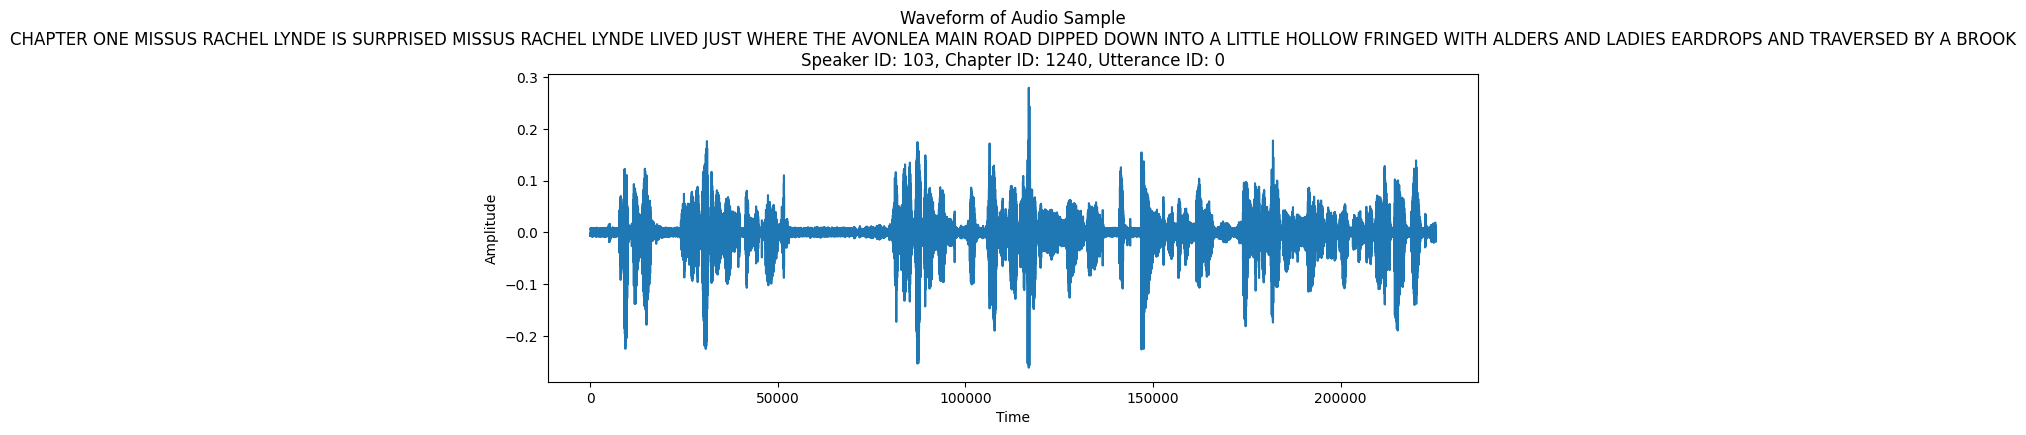

In [12]:
dataset_path = "./data"
train_dataset = torchaudio.datasets.LIBRISPEECH(root=dataset_path,url="train-clean-100",download=True)
test_dataset = torchaudio.datasets.LIBRISPEECH(root=dataset_path,url="test-clean",download=True)
test_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn_pad)
# Example: Access the first data point
waveform, sample_rate, utterance, speaker_id, chapter_id, utterance_id = train_dataset[0]

plt.figure(figsize=(12, 4))
plt.plot(waveform.t().numpy())
plt.title(f'Waveform of Audio Sample\n{utterance}\nSpeaker ID: {speaker_id}, Chapter ID: {chapter_id}, Utterance ID: {utterance_id}')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()


In [13]:
for data in test_loader:
    print(data)
    break

FileNotFoundError: [Errno 2] No such file or directory: './data\\LibriSpeech\\train-clean-100\\6272\\70191\\6272-70191.trans.txt'

In [4]:
type(train_dataset)

torchaudio.datasets.librispeech.LIBRISPEECH

In [5]:
ipd.Audio(waveform.numpy(), rate=sample_rate)

In [6]:
waveform.t().numpy().T
waveform.numpy()

array([[-0.00650024, -0.00552368, -0.00619507, ...,  0.0032959 ,
         0.00045776, -0.00946045]], dtype=float32)

In [7]:
waveform.t().numpy().shape

(225360, 1)

# We want to noise the data
# First noise

In [8]:
wave_form=np.copy(waveform.t().numpy()) #waveform -- tensor form, wave_form -- numpy form
print(wave_form)

[[-0.00650024]
 [-0.00552368]
 [-0.00619507]
 ...
 [ 0.0032959 ]
 [ 0.00045776]
 [-0.00946045]]


In [9]:
arr=np.array([1,2,3,4,500,6,7,8,9,10])
new_arr=arr+ np.random.uniform(arr*(-0.01), arr*0.01)
print("arr",arr)
print("new_arr",new_arr)

arr [  1   2   3   4 500   6   7   8   9  10]
new_arr [  0.99507142   2.01473584   3.0252132    4.00044117 504.42371093
   5.95970761   7.02965578   8.05904313   8.9245864   10.06913248]


In [10]:
noisy_arr=arr+ np.random.choice([-1,1],size=len(arr))*np.random.uniform(arr*(0.5), arr*0.7)
print("arr",arr)
print("noisy_arr",noisy_arr)

arr [  1   2   3   4 500   6   7   8   9  10]
noisy_arr [  1.52417803   0.99598181   4.9962157    6.44212974 803.65998089
   1.82575766   2.80678482  13.28553142   3.35146092   4.17282496]


In [11]:
np.random.choice([-1,1],size=len(arr))*np.random.uniform(arr*(0.5), arr*0.7)

array([ -0.58253371,  -1.12295563,  -1.72038367,   2.61184192,
       282.84981133,   4.19533697,  -4.56452173,   4.92069339,
         6.18910837,   5.86469169])

In [12]:
def make_first_noise(wave):
    #this process takes the wave and decreasing or increasing it randomly between (0.6,0.9) or (1.1,1.4)
    # the + random of half means that to the inetrval (0.6,0.9) we randomly add 0.5 or 0,
    # meaning half of the times it's (0.6,0.9) (decrease) and the other half (1.1,1.4) (increase)  
    return wave*(np.random.uniform(0.6,0.9,size=wave_form.shape)+np.random.choice([0,0.5],size=wave_form.shape))
first_noisy_wave_form= make_first_noise(wave_form)
print("wave_form",wave_form)
print("noisy_wave_form",first_noisy_wave_form)

wave_form [[-0.00650024]
 [-0.00552368]
 [-0.00619507]
 ...
 [ 0.0032959 ]
 [ 0.00045776]
 [-0.00946045]]
noisy_wave_form [[-0.00852348]
 [-0.00642051]
 [-0.00514945]
 ...
 [ 0.00371987]
 [ 0.00030056]
 [-0.00577187]]


In [ ]:
from torch.utils.data import Dataset, DataLoader

class CrappifiedDataset(Dataset):
    def __init__(self, clean_data, crappify_fn):
        """
        Dataset for crappifying clean data.
        
        :param clean_data: List or dataset of clean audio data.
        :param crappify_fn: A function that "crappifies" clean data.
        """
        self.clean_data = clean_data
        self.crappify_fn = crappify_fn

    def __len__(self):
        return len(self.clean_data)

    def __getitem__(self, idx):
        clean_sample = self.clean_data[idx]
        print(idx, clean_sample)
        crappified_sample = self.crappify_fn(clean_sample[0])
        print(crappified_sample)
        return torch.tensor(crappified_sample, dtype=torch.float32), torch.tensor(clean_sample, dtype=torch.float32)
    
    def __iter__(self):
        print("awd")
    
# Create the dataset
dataset = CrappifiedDataset(train_dataset, make_first_noise)

# Wrap in a DataLoader
data_loader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4)


In [ ]:
iter(data_loader)

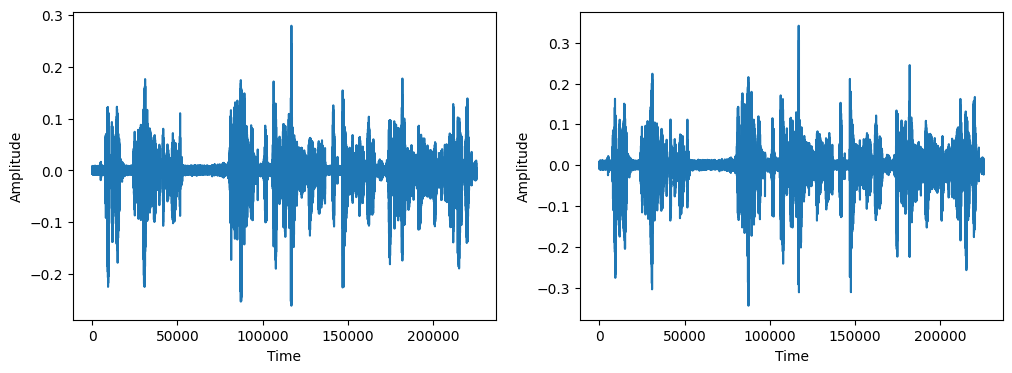

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
plt.plot(wave_form)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.subplot(1,2,2)
plt.plot(first_noisy_wave_form)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

In [16]:
ipd.Audio(first_noisy_wave_form.T, rate=sample_rate)

In [17]:
ipd.Audio(wave_form.T, rate=sample_rate)

# Second noise

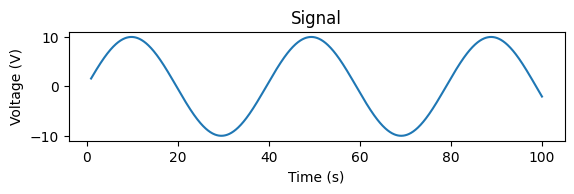

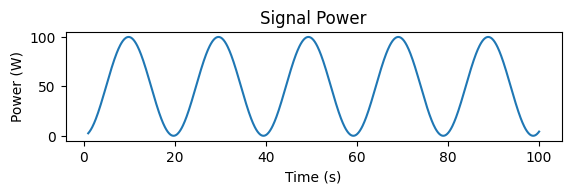

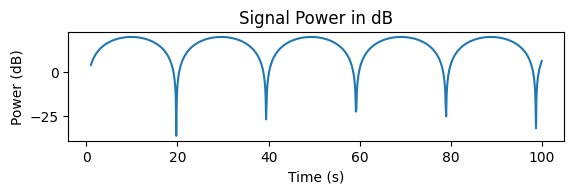

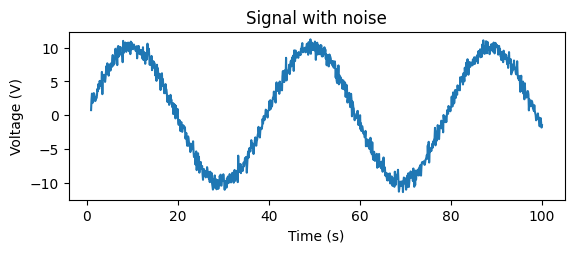

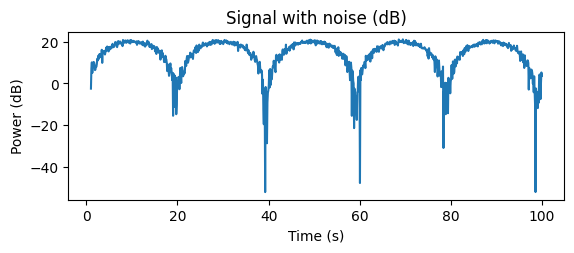

In [ ]:
# Signal Generation
# matplotlib inline


t = np.linspace(1, 100, 1000)
x_volts = 10*np.sin(t/(2*np.pi))
plt.subplot(3,1,1)
plt.plot(t, x_volts)
plt.title('Signal')
plt.ylabel('Voltage (V)')
plt.xlabel('Time (s)')
plt.show()

x_watts = x_volts ** 2
plt.subplot(3,1,2)
plt.plot(t, x_watts)
plt.title('Signal Power')
plt.ylabel('Power (W)')
plt.xlabel('Time (s)')
plt.show()

x_db = 10 * np.log10(x_watts)
plt.subplot(3,1,3)
plt.plot(t, x_db)
plt.title('Signal Power in dB')
plt.ylabel('Power (dB)')
plt.xlabel('Time (s)')
plt.show()
# Adding noise using target SNR

# Set a target SNR
target_snr_db = 20
# Calculate signal power and convert to dB 
sig_avg_watts = np.mean(x_watts)
sig_avg_db = 10 * np.log10(sig_avg_watts)
# Calculate noise according to [2] then convert to watts
noise_avg_db = sig_avg_db - target_snr_db
noise_avg_watts = 10 ** (noise_avg_db / 10)
# Generate an sample of white noise
mean_noise = 0
noise_volts = np.random.normal(mean_noise, np.sqrt(noise_avg_watts), len(x_watts))
# Noise up the original signal
y_volts = x_volts + noise_volts

# Plot signal with noise
plt.subplot(2,1,1)
plt.plot(t, y_volts)
plt.title('Signal with noise')
plt.ylabel('Voltage (V)')
plt.xlabel('Time (s)')
plt.show()
# Plot in dB
y_watts = y_volts ** 2
y_db = 10 * np.log10(y_watts)
plt.subplot(2,1,2)
plt.plot(t, 10* np.log10(y_volts**2))
plt.title('Signal with noise (dB)')
plt.ylabel('Power (dB)')
plt.xlabel('Time (s)')
plt.show()

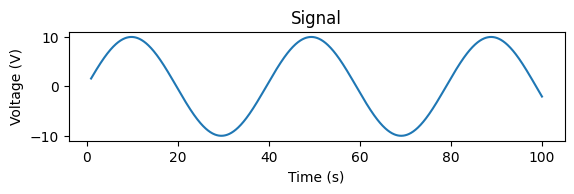

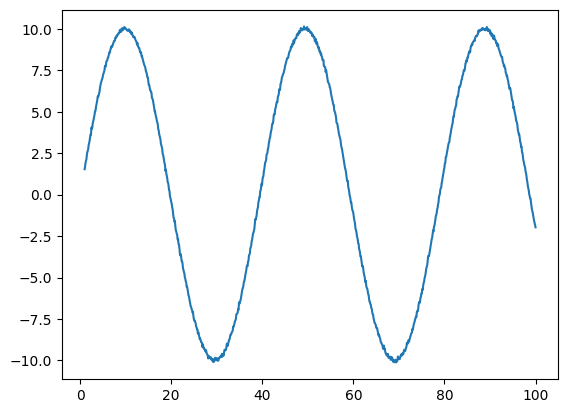

In [ ]:

t = np.linspace(1, 100, 1000)
x_volts = 10*np.sin(t/(2*np.pi))
plt.subplot(3,1,1)
plt.plot(t, x_volts)
plt.title('Signal')
plt.ylabel('Voltage (V)')
plt.xlabel('Time (s)')
plt.show()
samples = np.random.normal(0, np.max(np.abs(wave_form))*np.random.uniform(0.1, 0.4), size=x_volts.shape)

plt.plot(t,x_volts+samples)

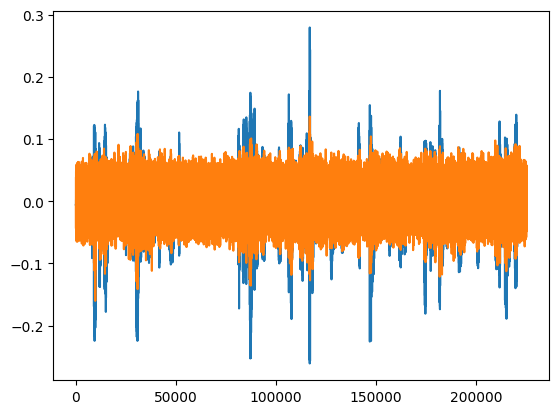

In [ ]:
def make_second_noise(wave):
    #here we add some White Noise using normal distribution,
    # the mean is 0, the variance is chosen randoml- it's the amplitude of the signal,
    # multiplied randomly by a value from the interval (0.1,0.3)
    # and then it is normelized to be with the norm of the original wave.
    samples = np.random.normal(0, np.max(np.abs(wave))*np.random.uniform(0.1, 0.2), size=wave.shape)
    return (wave+samples)*np.linalg.norm(wave)/np.linalg.norm(wave+samples)
second_noisy_wave_form=make_second_noise(wave_form)
plt.plot(wave_form)
plt.plot(second_noisy_wave_form)
plt.show()

In [21]:
ipd.Audio(second_noisy_wave_form.T, rate=sample_rate)

# Important
We need to decide what is the variance we take for the WN.\
i took now the max + min /2
I can just use the variance for the timesearise # איחוד הזירות

# Third Noise
lets add 2 voices together

In [22]:
def add_2_sounds(wave1,wave2): #adding wave1 to wave 2
    wave1_copy=np.copy(wave1)
    shape1=wave1.shape[0]
    shape2=wave2.shape[0]
    amplitude=np.random.uniform(0.15, 0.3)
    if (shape1<shape2):
        return wave1+amplitude*wave2[:wave1.shape[0],:]
    if(shape1==shape2):
        return wave1+amplitude*wave2
    residule=shape1
    for i in range(shape1//shape2):
        residule-=shape2
        wave1_copy[i*shape2:(i+1)*shape2,:]+=amplitude*wave2
    wave1_copy[shape1-residule:shape1,:]+=amplitude*wave2[:residule,:]
    return wave1_copy
def add_3_sounds(wave1,wave2,wave3):
    return add_2_sounds(add_2_sounds(wave1,wave2),wave3)
def make_third_noise(wave1,wave2,wave3):
    return add_3_sounds(wave1,wave2,wave3)

In [23]:
waveform1, sample_rate, utterance, speaker_id, chapter_id, utterance_id = train_dataset[0]
wave_form1=waveform1.t().numpy()
waveform2, _, utterance, speaker_id, chapter_id, utterance_id = train_dataset[1]
wave_form2=waveform2.t().numpy()
waveform3, _, utterance, speaker_id, chapter_id, utterance_id = train_dataset[2]
wave_form3=waveform3.t().numpy()
third_noisy_wave_form=make_third_noise(wave_form1,wave_form2,wave_form3)

In [24]:
ipd.Audio(third_noisy_wave_form.T, rate=sample_rate)

# Conclusion noise types.
we had 4 types of noise 
1) #### First type - disturbing the signal
This way take the wave, and in each time sample it is changed,<br>
for example, if in t=1sec the value is 0.1, then after noising it will <br>
randomly change to for example 0.13   <br>

2) #### Second type - adding white noise 
In this way, we add white noise to the samples.<br>
We do that using normal disribution, we add to the signal <br>
white noise with mean 0, and variance that is the amplidtude of the signal multipled <br>
randomly with a number between 0.1 and 0.3.  

3) #### Third type - adding talking in the background
Like in real life, when we have a recording, we have some times <br>
people talking in the backround, so in this method, we take the signal,<br> 
and add to it 2 different signals, to make the effect of people talking <br>
in the background.<br>

4) #### Fourth type - Combination 
Waves with the combination of all 3 previous types of errors.

# After defining our noises, lets apply them to the data

In [25]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, generator=g)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)